In [1]:
import math
import pandas as pd
import tensorflow as tf
# import keras_tuner.tuners as kt
import matplotlib.pyplot as plt
import keras
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
import numpy as np
import pickle
np.random.seed(0)
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv1D, Conv2D, LeakyReLU, MaxPool1D, AveragePooling1D, UpSampling1D, Flatten, Dense, Reshape, BatchNormalization
# https://towardsdatascience.com/improve-your-model-performance-with-auto-encoders-d4ee543b4154
from tensorflow.keras import initializers
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats import multivariate_normal
from keras.optimizers import Adam, SGD, Adadelta
from kmeans_gmm_eval_fns import gmm_model_get_prediction_ae, gmm_model_get_prediction_pca
import objects


In [2]:
x_train_scaled = pd.read_csv('../data/260_sample_train_scaled.csv').set_index("Patient_ID")
x_train_scaled

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,HDLBP,PIAS4,ADH1B,LOC100507531,FAM83A,NXF4,RNF125,DARS,DNAI1,MBTPS1
Patient_ID,,,,,,,,,,,,,,,,,,,,,
55_control,0.702813,0.799052,0.719665,0.729547,0.794953,0.256451,1.000000,0.363133,0.374212,0.611161,...,0.308725,0.235825,0.566757,0.982782,0.707526,1.000000,0.410887,0.671068,1.000000,0.438527
168_CD_plain,0.751408,0.603707,0.622768,0.627712,0.606860,0.520576,0.311962,0.251356,0.553554,0.441131,...,0.000000,0.000000,0.861588,0.000000,0.640911,0.020238,0.220356,0.632252,0.000000,0.488578
72_control,0.786508,0.755331,0.739605,0.756170,0.819875,0.391132,0.648401,0.134017,0.200420,0.679453,...,0.491401,0.279122,0.555258,0.000000,0.392175,0.000000,0.116289,0.000000,0.260194,0.531400
120_control,0.707491,0.662993,0.648072,0.764621,0.654276,0.633929,0.579519,0.248934,0.759250,0.755407,...,0.604918,0.598850,0.621841,0.000000,0.519941,0.000000,0.342185,0.416527,0.000000,0.545708
258_CD_plain,0.701039,0.662511,0.707208,0.834562,0.670160,0.410612,0.370517,0.244987,0.445387,0.798000,...,0.470835,0.670696,0.555250,0.000000,0.390923,0.000000,0.498504,0.449224,0.000000,0.689242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15_CD_plain,0.382762,0.384030,0.377332,0.360165,0.300915,0.340090,0.077348,0.890965,0.261140,0.205779,...,0.669319,0.770253,0.702931,0.000000,0.451846,0.000000,0.319644,0.549587,0.000000,0.935108
182_CD_plain,0.679910,0.584723,0.722426,0.643867,0.740014,0.650358,0.468650,0.295686,0.649939,0.609862,...,0.747236,0.742399,0.730485,0.000000,0.680460,0.000000,0.280413,0.529434,0.000000,0.606330
164_CD_plain,0.754656,0.556562,0.694062,0.748334,0.535534,0.133869,0.319071,0.154562,0.440487,0.824013,...,0.422981,0.769213,0.625325,0.000000,0.374319,0.000000,0.396084,0.590976,0.238307,0.753111


In [3]:
x_test_scaled = pd.read_csv('../data/260_sample_test_scaled.csv').set_index("Patient_ID")
x_test_scaled

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,HDLBP,PIAS4,ADH1B,LOC100507531,FAM83A,NXF4,RNF125,DARS,DNAI1,MBTPS1
Patient_ID,,,,,,,,,,,,,,,,,,,,,
253_CD_plain,0.869185,0.841880,0.930171,0.886737,0.835678,0.297964,0.668498,0.266670,0.278122,0.933520,...,0.775985,0.973492,0.472825,0.0,0.269797,0.0,0.539781,0.290165,0.000000,0.722611
105_CD_plain,0.853562,0.933532,0.942213,0.794578,0.890482,0.206529,0.298987,0.350745,0.495663,0.849038,...,0.582213,0.531660,0.540145,0.0,0.322049,0.0,0.303573,0.133159,0.000000,0.537012
2_CD_plain,0.165531,0.141475,0.263684,0.198091,0.160503,0.888878,0.000000,0.134461,0.989132,0.202203,...,0.907365,0.736128,-0.336653,0.0,-0.069528,0.0,0.176989,0.766373,0.000000,1.094845
184_CD_plain,0.717121,0.660314,0.769417,0.752737,0.694874,0.514735,0.692365,0.271127,0.650742,0.694599,...,0.648501,0.789699,0.836996,0.0,0.285660,0.0,0.320280,0.488913,0.000000,0.674738
312_CD_plain,0.730072,0.722909,0.713076,0.743545,0.679258,0.308459,0.399235,0.129019,0.597529,0.720390,...,0.493294,0.566990,0.807264,0.0,0.471971,0.0,0.462733,0.508932,0.000000,0.693707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107_CD_plain,0.736123,0.658232,0.772323,0.685637,0.658755,0.250970,0.247307,0.422075,0.555944,0.603675,...,0.550182,0.719685,0.701615,0.0,0.225656,0.0,0.295914,0.701896,0.000000,0.709542
279_CD_plain,0.220614,0.202090,0.182810,0.113245,0.105744,0.699851,0.000000,0.908485,0.688912,0.178259,...,0.819116,0.689739,0.213157,0.0,0.969447,0.0,0.134090,0.710444,0.000000,0.846294
179_CD_plain,0.724476,0.726774,0.766943,0.776284,0.690339,0.380637,0.440449,0.318944,0.558600,0.738787,...,0.417027,0.734039,0.683655,0.0,0.369566,0.0,0.405814,0.575430,0.000000,0.653918


In [4]:
patient_ids_train = np.array(x_train_scaled.index)
patient_ids_test = np.array(x_test_scaled.index)
patient_ids_train

array(['55_control', '168_CD_plain', '72_control', '120_control',
       '258_CD_plain', '254_CD_deep_ulcer', '9_CD_plain', '111_CD_plain',
       '57_CD_plain', '216_CD_deep_ulcer', '263_CD_deep_ulcer',
       '95_CD_deep_ulcer', '31_control', '172_CD_plain', '310_CD_plain',
       '68_CD_plain', '65_control', '285_CD_plain', '201_CD_plain',
       '223_CD_deep_ulcer', '320_CD_plain', '8_CD_plain',
       '99_CD_deep_ulcer', '90_control', '296_CD_deep_ulcer',
       '219_CD_deep_ulcer', '138_CD_deep_ulcer', '38_control',
       '113_CD_plain', '76_control', '146_CD_deep_ulcer',
       '147_CD_deep_ulcer', '186_CD_plain', '158_CD_plain',
       '299_CD_plain', '178_CD_plain', '189_CD_plain', '266_CD_plain',
       '231_CD_deep_ulcer', '198_CD_plain', '6_CD_deep_ulcer',
       '30_CD_plain', '265_CD_plain', '181_CD_deep_ulcer', '16_CD_plain',
       '264_CD_deep_ulcer', '209_CD_plain', '83_control', '214_CD_plain',
       '193_CD_deep_ulcer', '104_CD_plain', '66_CD_plain', '188_CD_plain

In [5]:
def classify(x):
    if "_control" in x: # control
        return 0
    elif "CD_plain" in x: # Crohn's Disease no deep ulcer
#         print(x)
        return 1
    elif "CD_deep_ulcer" in x: # Crohn's Disease deep ulcer
#         print(x)
        return 2
    else:
        return 3 # Ulcerative Collitis

vec = np.vectorize(classify)

disease_labels_train = vec(patient_ids_train)
disease_labels_test = vec(patient_ids_test)
disease_labels_train

array([0, 1, 0, 0, 1, 2, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 0, 1, 1, 2, 1, 1,
       2, 0, 2, 2, 2, 0, 1, 0, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2,
       1, 2, 1, 0, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 2, 2, 2, 1, 0, 0, 0, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 0, 1, 2,
       1, 2, 0, 0, 1, 2, 2, 1, 1, 2, 2, 0, 1, 2, 1, 2, 1, 0, 2, 1, 1, 1,
       2, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 0, 1, 1, 0, 2, 2, 2, 0, 1, 1, 2,
       2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 1, 1, 1, 1, 2, 1, 1,
       1, 2, 1, 1, 0, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 2, 0,
       0, 1, 1, 1, 1, 1])

In [6]:
# compound_model = keras.models.load_model('cd_clf')

In [7]:
# compound_model.summary()

## SHAP evaluation

In [8]:
x_test_scaled.iloc[:2,:2]

,AADAC,APOA1
Patient_ID,,
253_CD_plain,0.869185,0.841880
105_CD_plain,0.853562,0.933532


In [9]:
import objects

In [10]:
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_test_scaled, link="logit", feature_dependence=True)

getting explainerinitialising explainer
link.f
link.f
link.f
link.f


## Calculate SHAP values

In [11]:
# shap_values = explainer.shap_values(X=x_test_scaled)

In [12]:
# shap_values

## Save SHAP values

In [13]:
# with open("shap_values", "wb") as fp:   #Pickling
#     pickle.dump(shap_values, fp)

In [14]:


with open("../data/models/shap/new_ind_all_750", "rb") as fp:   # Unpickling
# with open("../shap_values", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [15]:
shap_values = shap_values[0]

In [16]:
shap_values

[array([[  0.        ,  -1.6545877 ,   0.        , ...,   0.36572861,
          -1.58913482,  -2.00706   ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        , -11.13111799, -18.10008457, ...,   6.61884202,
          11.63849777,  10.95442213],
        ...,
        [ -0.67290678,  -0.3608185 ,  -3.47873713, ...,   2.64421844,
          -0.81989195,  -2.41452355],
        [ -1.14471457,  -3.7409408 ,  -2.48231731, ...,   2.56361903,
           0.        ,   4.06901461],
        [  0.        ,  -1.84789495,  -1.46251144, ...,   1.17632954,
          -1.7643807 ,   0.        ]]),
 array([[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [ -7.96718864,   6.51841375, -26.45116542, ...,  -1.2813746 ,
           9.8805868 , -23.8796136 ],
        [ 13.389368  ,   0.        ,  -5.9132596 , ...,  -5.15178573,
          -7.61376374,  17.22536019],
        ...,


In [17]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (78, 220)


Target Classes:
0: control
1: CD no ulcer
2: CD deep ulcer

## Patient-specific plots

In [18]:
idx = 18
patient = x_test_scaled.iloc[[idx],:]
patient

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,HDLBP,PIAS4,ADH1B,LOC100507531,FAM83A,NXF4,RNF125,DARS,DNAI1,MBTPS1
Patient_ID,,,,,,,,,,,,,,,,,,,,,
46_CD_deep_ulcer,0.438089,0.482152,0.410237,0.378247,0.438691,0.705762,0.339106,0.559666,0.878088,0.228893,...,0.964177,0.715558,0.716592,0.0,0.684122,0.0,0.136883,0.624877,0.0,0.877226


In [19]:
gmm_model_get_prediction_ae(patient)[0]

array([9.19121317e-23, 6.06741518e-04, 9.99393258e-01])

In [20]:
print(f'Prediction probabilities for patient: {gmm_model_get_prediction_ae(patient)[0]}')
print("Predicted class:",np.argmax(gmm_model_get_prediction_ae(patient)[0]))

Prediction probabilities for patient: [9.19121317e-23 6.06741518e-04 9.99393258e-01]
Predicted class: 2


#### Control

In [21]:
import shap

In [22]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][idx,:], patient, link="logit")

####  CD no ulcer

In [23]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][idx,:], patient, link="logit")

####  CD deep ulcer

In [24]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][idx,:], patient, link="logit")

In [25]:
# gene_shap.plots.bar(Explanation(x_test_scaled)[0], clustering=clustering)
idx = 18
explanation = objects.get_explanation(values=shap_values[2][idx], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

getting explanation


_explanation.Explanation

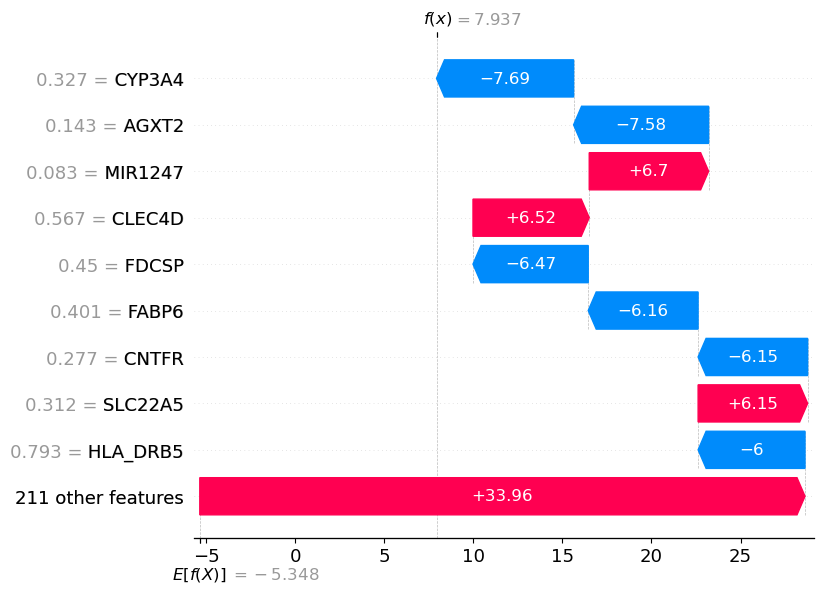

In [26]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))

#### Control

In [27]:
# shap.initjs()
# shap.force_plot(explainer.expected_value[0], shap_values[0], x_test_scaled)

####  CD no ulcer

In [28]:
# shap.initjs()
# shap.force_plot(explainer.expected_value[1], shap_values[1], x_test_scaled)

####  CD deep ulcer

In [29]:
# shap.initjs()
# shap.force_plot(explainer.expected_value[2], shap_values[2], x_test_scaled)

## SHAP Summary Plots

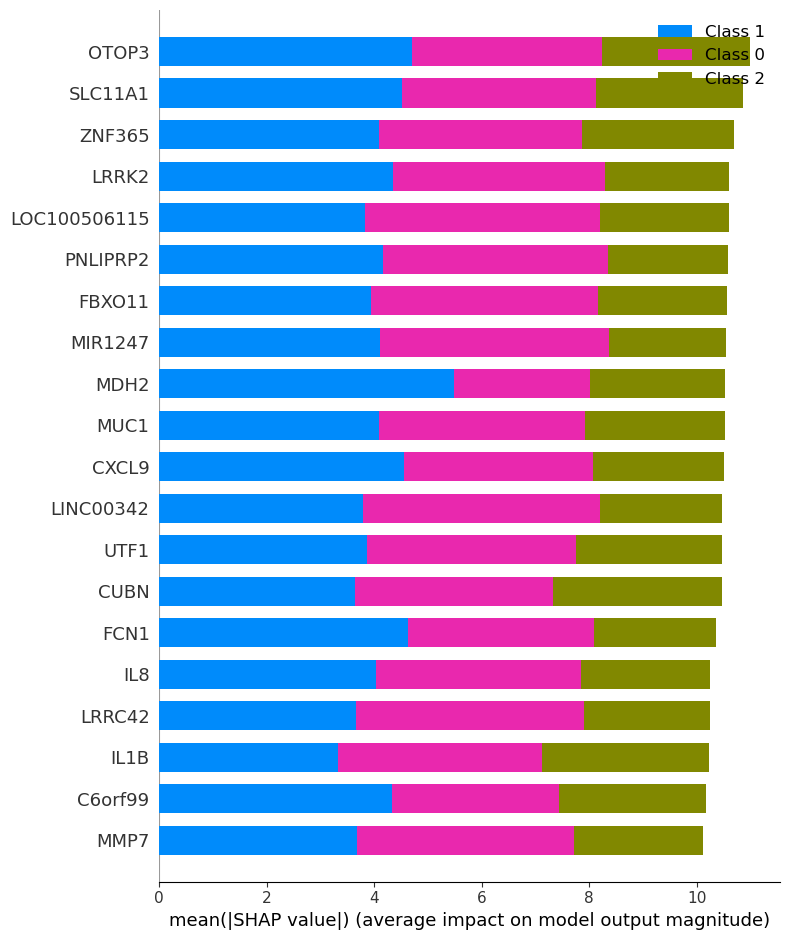

In [30]:
shap.summary_plot(shap_values, x_test_scaled)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


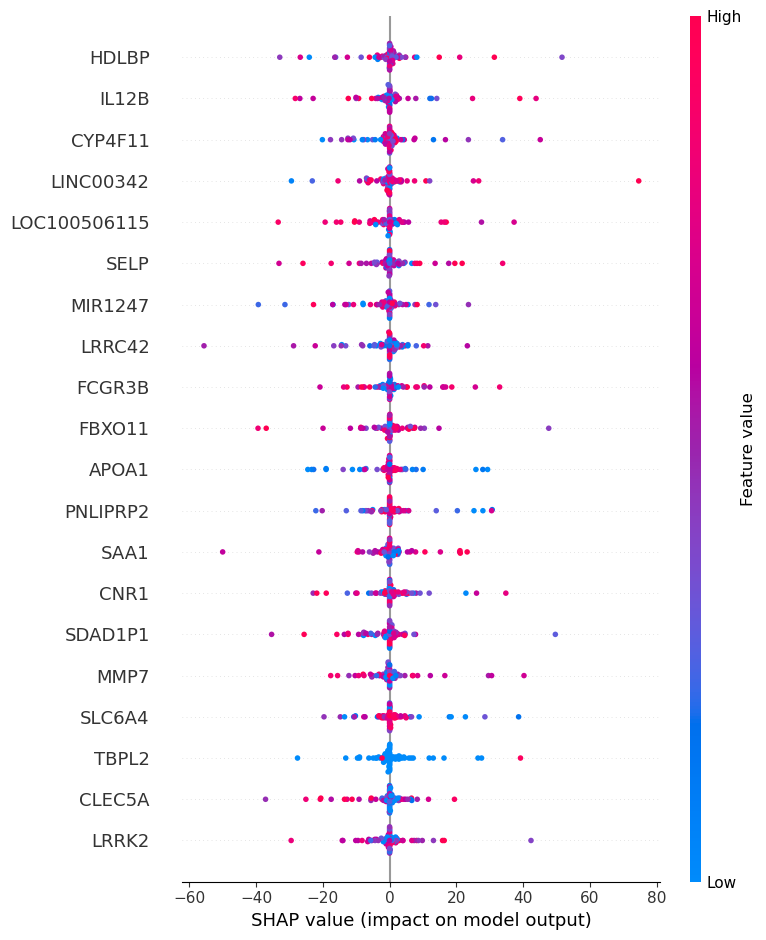

In [31]:
# control
shap.summary_plot(shap_values[0], x_test_scaled)

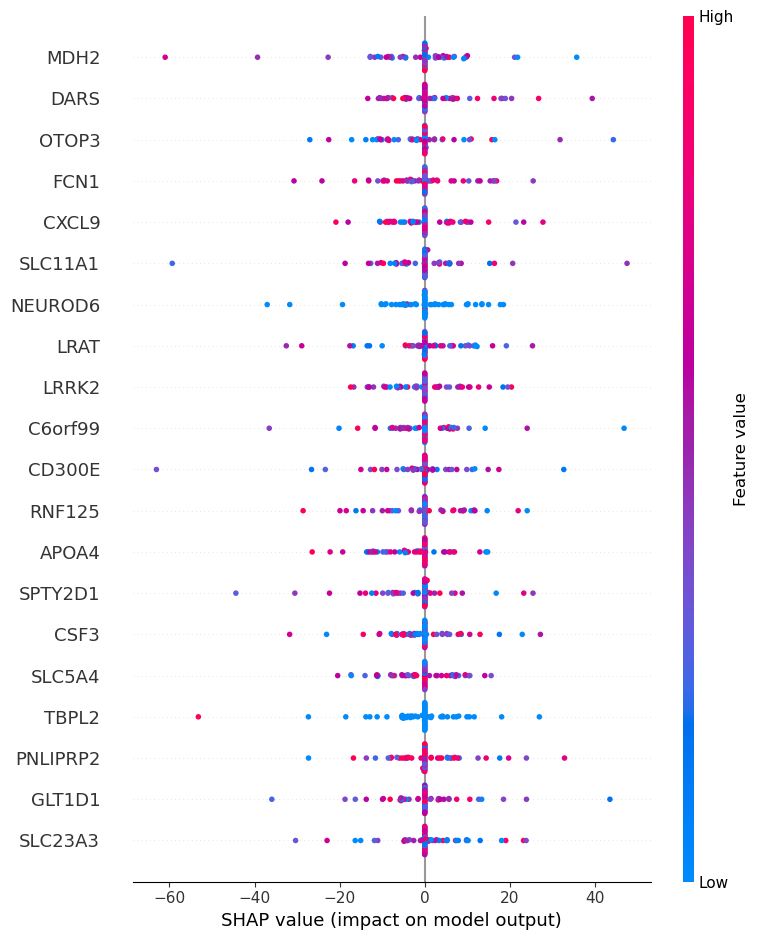

In [32]:
# CD no ulcer
shap.summary_plot(shap_values[1], x_test_scaled)

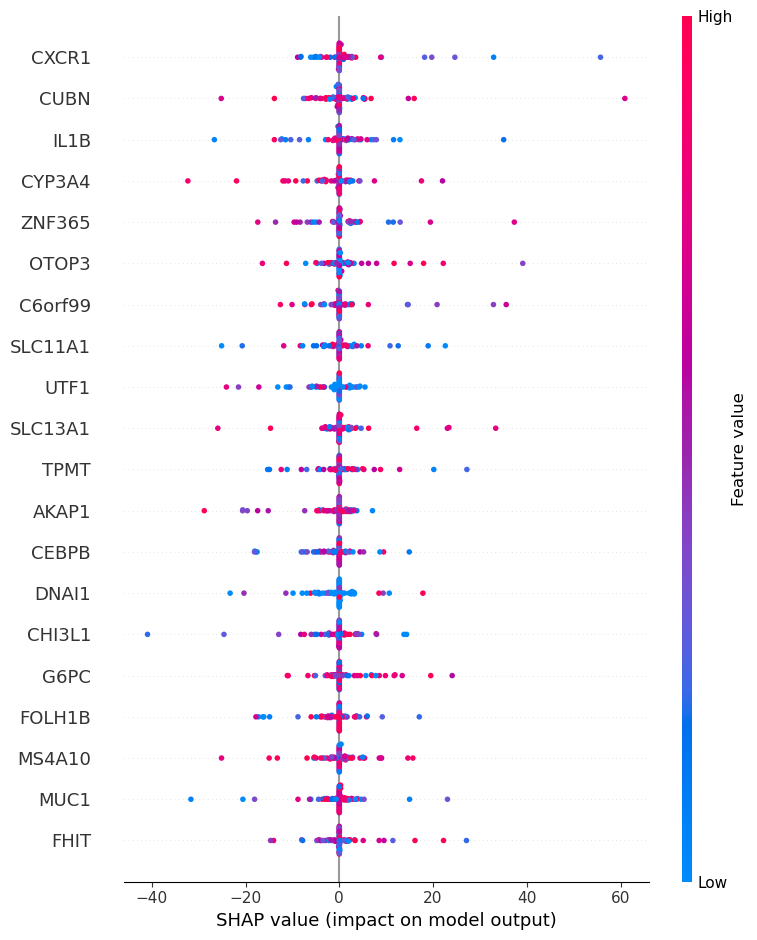

In [33]:
# CD deep ulcer
shap.summary_plot(shap_values[2], x_test_scaled)

## SHAP Dependence Plots

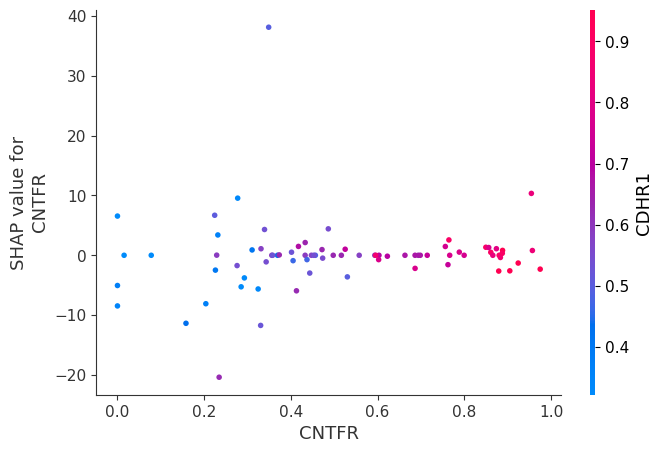

In [34]:
# control
shap.dependence_plot("CNTFR", shap_values[0], x_test_scaled)

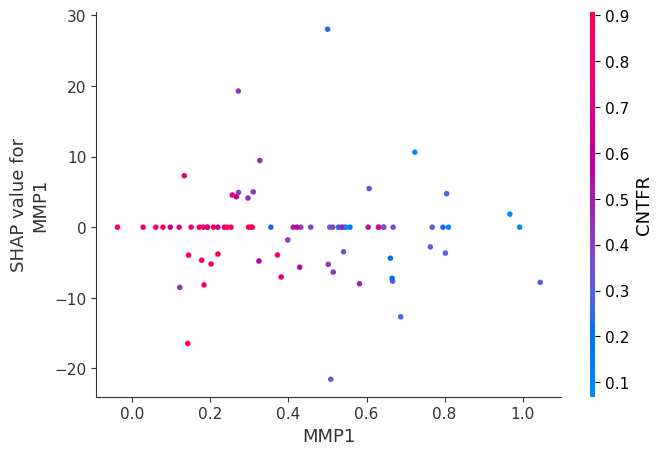

In [35]:
# CD no ulcer
shap.dependence_plot("MMP1", shap_values[1], x_test_scaled)

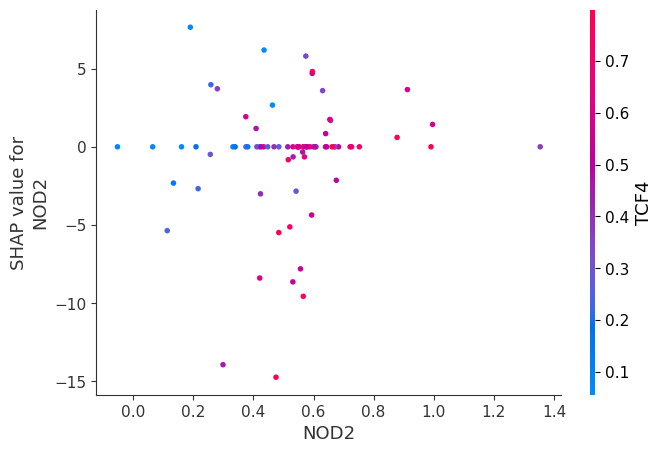

In [36]:
# CD deep ulcer
shap.dependence_plot("NOD2",shap_values[2], x_test_scaled)

## Clustering

In [37]:
disease_labels_test.shape

(78,)

In [38]:
# sys.stdout = open(1, 'w')
import sys
stdout = sys.stdout
sys.stdout = sys.__stdout__

### Current SHAP functionality

In [39]:
clustering = objects.get_clustering(x_test_scaled, disease_labels_test)

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
No/low signal found from feature 13 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
 78%|██████████████████████████████████████████████████████████████▌                 | 172/220 [01:10<00:19,  2.44it/s]No/low signal found from feature 171 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
No/low signal found from feature 172 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
 98%|██████████████████████████████████████████████████████████████████████████████▌ | 216/220 [01:27<00:01,  3.16it/s]No/low signal found from feature 215 (this is typically cause

In [40]:
# clustering

In [41]:
# clustering.shape

In [42]:
row = 77
exp = shap.Explanation(values=shap_values[2][row], base_values=explainer.expected_value[2], 
                                data=x_test_scaled.iloc[row], feature_names=x_test_scaled.columns.tolist())

# patient 8: explanations for CD deep ulcer diagnosis

In [43]:
type(exp)

shap._explanation.Explanation

In [44]:
# with open("clust", "wb") as fp:   #Pickling
#     pickle.dump(clustering, fp)

In [45]:

# with open("../clust", "rb") as fp:   # Unpickling
#     clustering = pickle.load(fp)

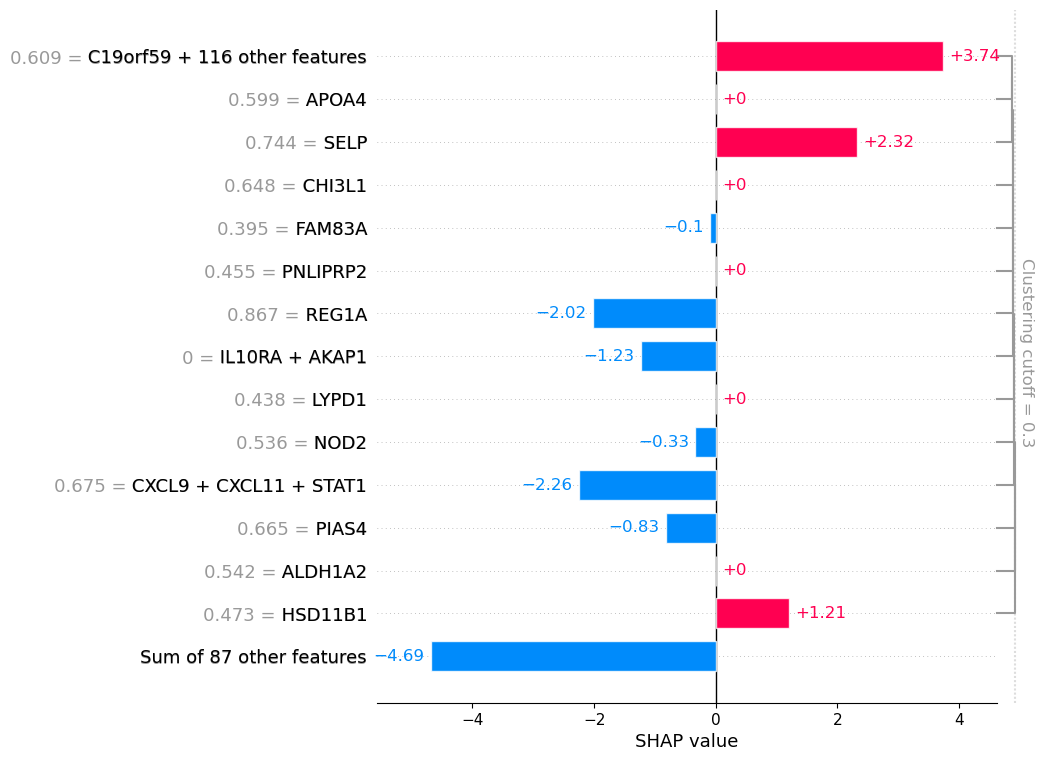

In [46]:
import shap
# shap.plots.bar(explanation, clustering=clustering)
shap.plots.bar(exp, max_display=15, clustering_cutoff=0.3,
               clustering=clustering)

## Hierarchical clustering of genes based on shap values, across all patients with given disease classification

In [47]:
from scipy.cluster.hierarchy import dendrogram, linkage, leaders, fcluster
import seaborn as sns

In [48]:


all_gene_df = pd.DataFrame(shap_values[2], index=x_test_scaled.index, columns = x_test_scaled.columns)
df_cd_deep = all_gene_df[all_gene_df.index.str.endswith('_CD_deep_ulcer')]
df_cd_plain = all_gene_df[all_gene_df.index.str.endswith('_CD_plain')]
df_control = all_gene_df[all_gene_df.index.str.endswith('_control')]
df_cd_deep

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,HDLBP,PIAS4,ADH1B,LOC100507531,FAM83A,NXF4,RNF125,DARS,DNAI1,MBTPS1
Patient_ID,,,,,,,,,,,,,,,,,,,,,
62_CD_deep_ulcer,0.000000,0.000000,1.931259,-0.350015,0.000000,0.360278,0.404263,0.797229,-1.033852,0.694627,...,2.373393,-2.943102,1.558333,0.000000,0.920982,1.580758,0.000000,0.000000,-5.077822,1.256318
167_CD_deep_ulcer,-6.654139,4.915710,4.934115,2.677951,-0.145923,-2.421157,-0.166192,6.580406,-8.225060,0.000000,...,-6.405778,1.086161,3.604187,-2.905432,-1.523396,4.518619,0.161242,-1.175233,2.726538,0.000000
196_CD_deep_ulcer,0.000000,0.000000,0.000000,0.345313,0.000000,0.000000,0.000000,0.000000,0.000000,-2.957158,...,-3.806868,2.292594,0.591138,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.279962
23_CD_deep_ulcer,-2.285291,2.260944,-2.032097,0.000000,0.000000,0.000000,-0.875571,-0.918038,7.863664,1.921859,...,0.289721,1.372420,0.000000,0.000000,0.000000,0.000000,0.000000,2.277828,-4.522922,0.000000
93_CD_deep_ulcer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-0.046878,0.000000,0.000000,0.000000,0.000000,-0.221614,0.000000,0.000000
229_CD_deep_ulcer,0.000000,1.532119,-0.477323,0.021247,0.000000,-0.227507,0.000000,0.000000,0.000000,2.270888,...,0.000000,0.535149,0.703016,-0.246366,0.000000,0.917893,4.019210,0.000000,-1.694824,-0.758933
46_CD_deep_ulcer,1.158281,4.683718,-1.147227,0.000000,1.888567,-1.628206,-2.355034,-4.422003,1.789294,2.960566,...,-1.252662,2.243855,2.141418,-3.879509,0.597877,0.000000,2.869557,0.002714,3.074680,3.120305
176_CD_deep_ulcer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.085066,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
49_CD_deep_ulcer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.846570,0.000000,0.000000,0.000000


### Example: CD deep ulcer patients

In [49]:
# patient_cluster_cd_deep = linkage(df_cd_deep, 'ward', metric='euclidean', optimal_ordering=True)
gene_cluster_cd_deep = linkage(df_cd_deep.T, 'ward', metric='euclidean', optimal_ordering=True)

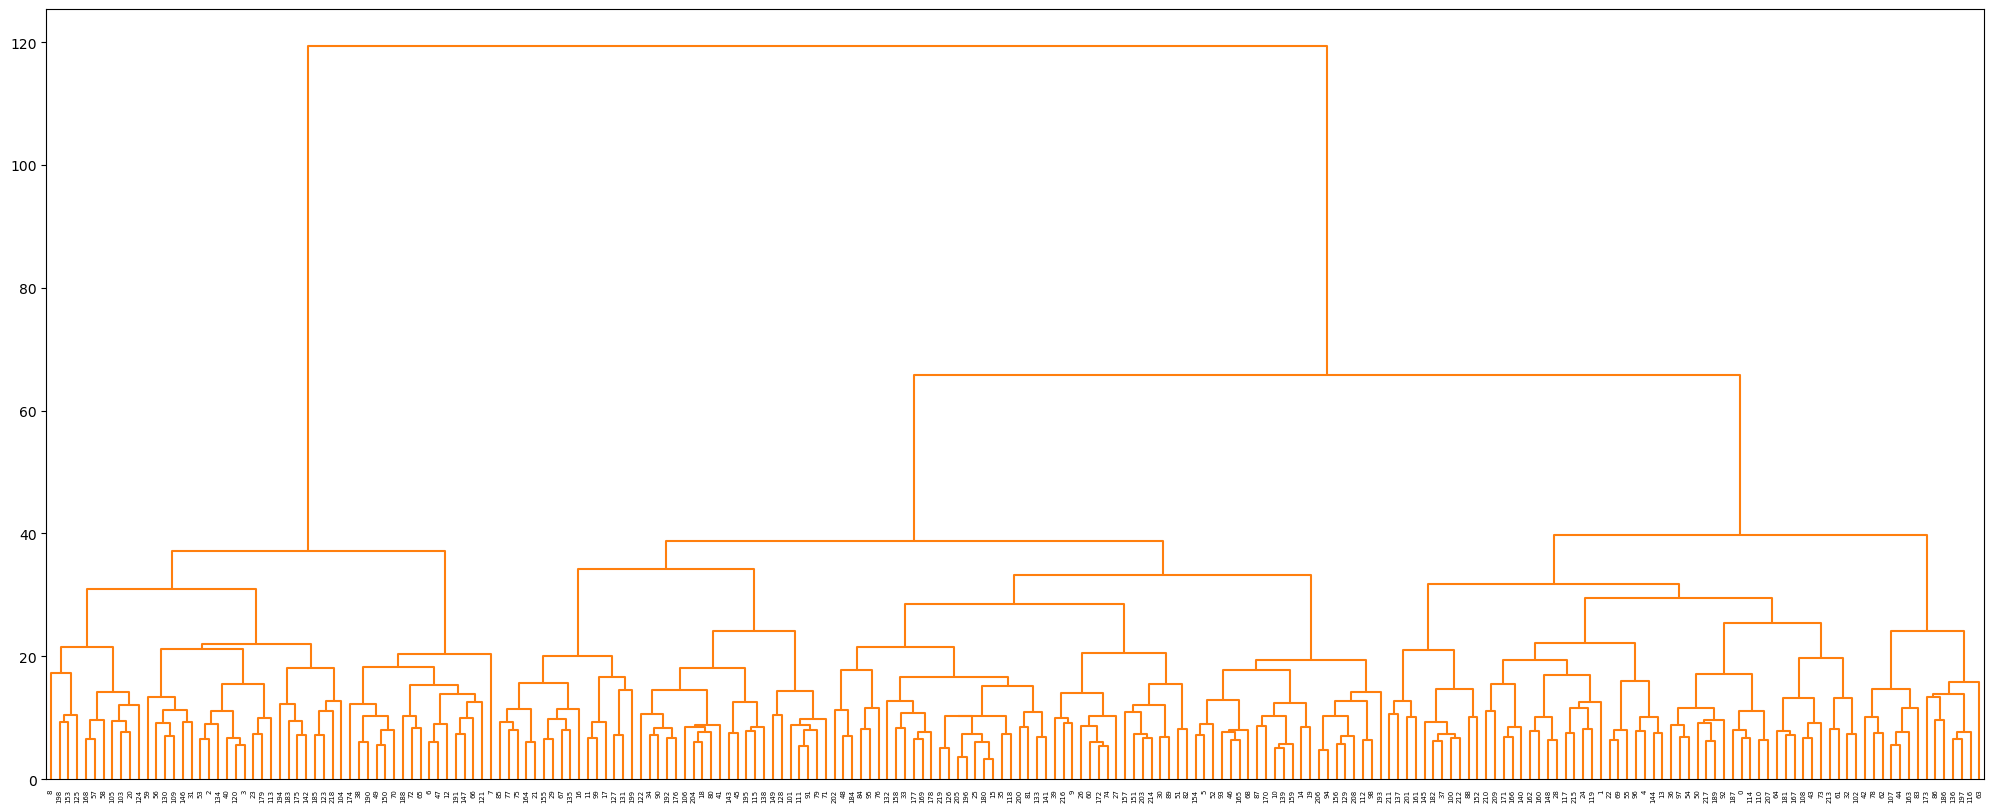

In [50]:
thresh=250
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_deep, color_threshold = thresh, get_leaves=True)
# dn = dendrogram(fl)
plt.axhline(y=thresh, c='r', linestyle='--')

In [51]:
dn_ids = np.asarray(dn['ivl'], dtype='int')
dn_ids

array([  8, 198, 153, 125, 168,  57,  58, 105, 103,  20, 124,  59,  56,
       130, 109, 146,  31,  53,   2, 134,  40, 120,   3,  23, 179, 113,
       194, 183, 175, 142, 185, 123, 218, 104, 174,  38, 190,  49, 150,
        70, 188,  72,  65,   6,  47,  12, 191, 147,  66, 121,   7,  85,
        77,  75, 164,  21, 155,  29,  67, 135,  16,  11,  99,  17, 127,
       131, 199, 122,  34,  90, 192, 176, 106, 204,  18,  80,  41, 143,
        45, 195, 115, 138, 149, 128, 101, 111,  91,  79,  71, 202,  48,
       184,  84,  95,  76, 132, 158,  33, 177, 169, 178, 219, 126, 205,
       196,  25, 180,  15,  35, 118, 200,  81, 133, 141,  39, 216,   9,
        26,  60, 172,  74,  27, 157, 151, 203, 214,  30,  89,  51,  82,
       154,   5,  52,  93,  46, 165,  68,  87, 170,  10, 139, 159,  14,
        19, 206,  94, 156, 129, 208, 112,  98, 193, 211, 137, 201, 161,
       145, 182,  37, 100, 212,  88, 152, 210, 209, 171, 166, 140, 162,
       160, 148,  28, 117, 215,  24, 119,   1,  22,  69,  55,  9

In [52]:
df_cd_deep.columns

Index(['AADAC', 'APOA1', 'APOA4', 'APOB', 'APOC3', 'AQP9', 'C6', 'CEACAM7',
       'CHI3L1', 'ABCC2',
       ...
       'HDLBP', 'PIAS4', 'ADH1B', 'LOC100507531', 'FAM83A', 'NXF4', 'RNF125',
       'DARS', 'DNAI1', 'MBTPS1'],
      dtype='object', length=220)

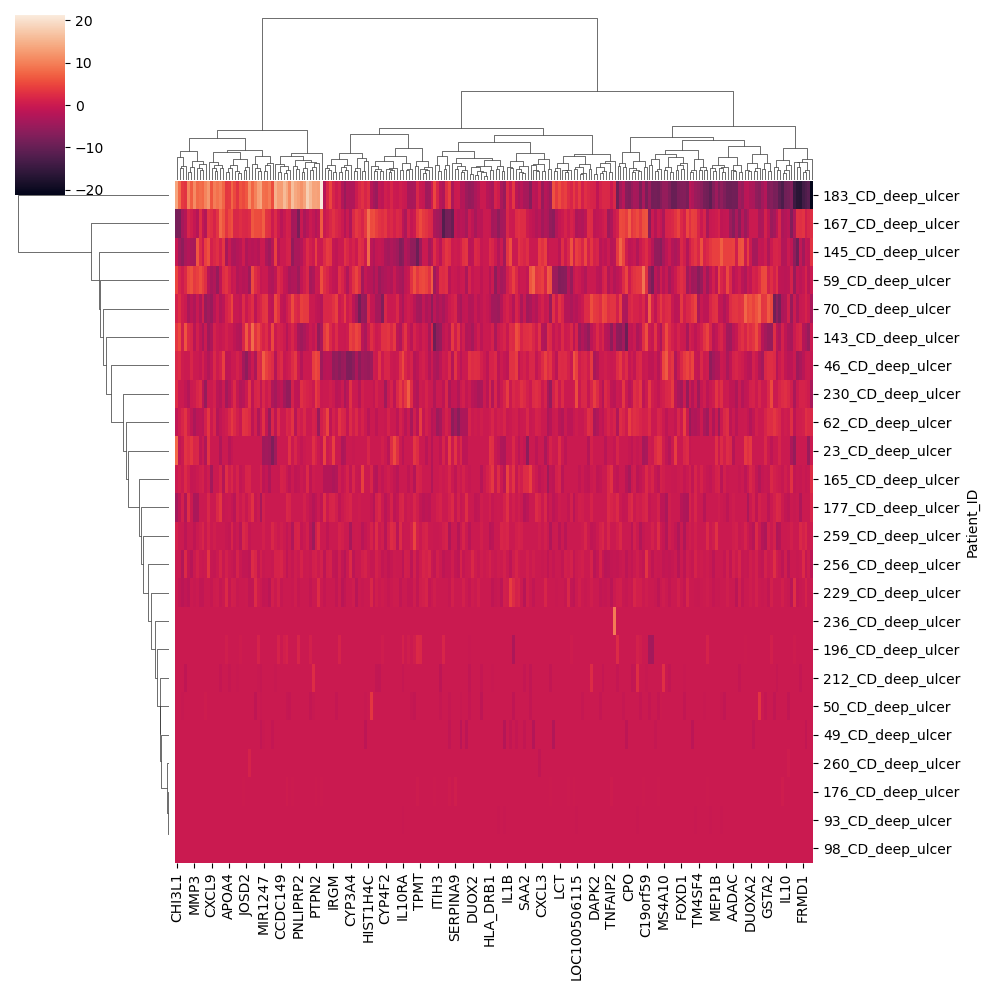

In [53]:
# shap values across genes (CD deep ulcer) - shows contribution of genes to disease symptom prediction for patients with given symptoms

# g = sns.clustermap(df_cd_deep, col_linkage=gc, row_linkage=patient_cluster_cd_deep)
g = sns.clustermap(df_cd_deep, col_linkage=gene_cluster_cd_deep)

## Aggregate bar plot, showing possible gene modules alongside SHAP contributions

In [54]:
gene_cluster_cd_deep

array([[180.        ,  15.        ,   3.30540035,   2.        ],
       [205.        , 196.        ,   3.6525951 ,   2.        ],
       [206.        ,  94.        ,   4.8210536 ,   2.        ],
       [219.        , 126.        ,   5.05416467,   2.        ],
       [ 10.        , 139.        ,   5.09278697,   2.        ],
       [111.        ,  91.        ,   5.38893387,   2.        ],
       [172.        ,  74.        ,   5.47862701,   2.        ],
       [120.        ,   3.        ,   5.50207751,   2.        ],
       [ 49.        , 150.        ,   5.53215004,   2.        ],
       [107.        ,  44.        ,   5.55180246,   2.        ],
       [156.        , 129.        ,   5.65077237,   2.        ],
       [224.        , 159.        ,   5.77416792,   3.        ],
       [ 38.        , 190.        ,   6.03354273,   2.        ],
       [164.        ,  21.        ,   6.04448634,   2.        ],
       [  6.        ,  47.        ,   6.05396032,   2.        ],
       [ 60.        , 226

In [55]:
cluster_labels = fcluster(gene_cluster_cd_deep, .7, criterion='distance')
# label = fcluster(gene_cluster_cd_deep, 8, criterion='maxclust')
cluster_labels.shape

(220,)

In [56]:
leaders(gene_cluster_cd_deep, cluster_labels)

(array([198, 153, 125,   8, 168,  57,  58, 103,  20, 105, 124, 130, 109,
         56, 146,  31,  59,  53,   2, 134, 120,   3,  40,  23, 179, 113,
        175, 142, 183, 194, 185, 123, 218, 104,  38, 190,  49, 150,  70,
        174,  72,  65, 188,   6,  47,  12, 191, 147,  66, 121,   7,  77,
         75,  85, 164,  21, 155,  29,  67, 135,  16,  11,  99,  17, 127,
        131, 199,  34,  90, 192, 176, 122, 204,  18,  80, 106,  41, 143,
         45, 195, 115, 138, 149, 128, 111,  91,  79, 101,  71,  48, 184,
        202,  84,  95,  76, 158,  33, 177, 169, 178, 132, 219, 126, 205,
        196, 180,  15,  25,  35, 118, 200,  81, 133, 141, 216,   9,  39,
        172,  74,  60,  26,  27, 203, 214, 151, 157,  30,  89,  51,  82,
        154,   5,  52,  46, 165,  93,  68,  87, 170,  10, 139, 159,  14,
         19, 206,  94, 156, 129, 208, 112,  98, 193, 211, 137, 201, 161,
        182,  37, 100, 212, 145,  88, 152, 210, 209, 171, 166, 140, 162,
        160, 148,  28, 117, 215,  24, 119,   1,  22

In [57]:
leader_ids = leaders(gene_cluster_cd_deep, cluster_labels)[1]
leader_ids

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [58]:
cluster_labels

array([192, 177,  19,  22, 182, 132,  44,  51,   4, 116, 140,  62,  46,
       184, 143, 107,  61,  64,  74, 144,   9,  56, 178,  24, 175, 108,
       121, 122, 172,  58, 127,  16, 205,  97,  68, 109, 187, 158,  35,
       117,  23,  77, 209, 201, 211,  79, 134,  45,  90,  37, 190, 129,
       133,  18, 186, 180,  14,   6,   7,  17, 120, 204, 208, 220, 199,
        42,  49,  59, 137, 179,  39,  89,  41, 202, 119,  53,  95,  52,
       207,  87,  75, 112, 130, 213,  93,  54, 214, 138, 162, 128,  69,
        86, 191, 136, 146,  94, 181, 185, 151,  63, 159,  88, 206,   8,
        34,  10,  76, 210, 200,  13, 195,  85, 150,  26, 193,  81, 219,
       173, 110, 176,  21,  50,  72,  32,  11,   3, 103,  65,  84, 148,
        12,  66, 101, 113,  20,  60, 217, 154,  82, 141, 168, 114,  28,
        78, 183, 161,  15,  48, 171,  83,  38, 125, 163,   2, 131,  57,
       147, 126,  96, 142, 170, 156, 169, 212,  55, 135, 167, 198,   5,
        99, 139, 166, 118, 216,  40,  27,  71,  98, 100,  25, 10

In [59]:
df_cd_deep.columns.get_loc("OSM")

63

In [60]:
np.where(cluster_labels == 2) #osm

(array([153], dtype=int64),)

In [61]:
gene_df = df_cd_deep.describe().T
gene_df['gene_symbol']  = df_cd_deep.columns
gene_df["group_num"] = cluster_labels

gene_df

,count,mean,std,min,25%,50%,75%,max,gene_symbol,group_num
AADAC,24.0,-0.481339,2.660540,-8.802835,-0.314549,0.0,0.096411,4.580193,AADAC,192
APOA1,24.0,-0.456344,2.900831,-8.107030,-0.641038,0.0,0.121282,4.915710,APOA1,177
APOA4,24.0,0.309454,1.598048,-2.032097,-0.444751,0.0,0.142574,4.934115,APOA4,19
APOB,24.0,-0.174357,1.694010,-2.717243,-0.924777,0.0,0.000000,5.844706,APOB,22
APOC3,24.0,-0.096944,2.162096,-6.376530,0.000000,0.0,0.000000,5.814678,APOC3,182
...,...,...,...,...,...,...,...,...,...,...
NXF4,24.0,-0.368522,2.193438,-7.448610,-0.332528,0.0,0.009629,4.518619,NXF4,174
RNF125,24.0,0.671948,1.613249,-1.325706,0.000000,0.0,0.392177,5.668697,RNF125,115
DARS,24.0,0.194273,2.145226,-5.931924,-0.124797,0.0,0.000678,6.991176,DARS,188
DNAI1,24.0,-0.238973,2.867939,-5.077822,-1.057446,0.0,0.000000,9.361650,DNAI1,33


In [62]:
# mean_df = gene_df[['mean','group_num']]
mean_df = gene_df[['mean','group_num','gene_symbol']]
mean_df

,mean,group_num,gene_symbol
AADAC,-0.481339,192,AADAC
APOA1,-0.456344,177,APOA1
APOA4,0.309454,19,APOA4
APOB,-0.174357,22,APOB
APOC3,-0.096944,182,APOC3
...,...,...,...
NXF4,-0.368522,174,NXF4
RNF125,0.671948,115,RNF125
DARS,0.194273,188,DARS
DNAI1,-0.238973,33,DNAI1


In [63]:

mean_df["gene_symbol"] = mean_df.index
mean_df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,mean,group_num,gene_symbol
AADAC,-0.481339,192,AADAC
APOA1,-0.456344,177,APOA1
APOA4,0.309454,19,APOA4
APOB,-0.174357,22,APOB
APOC3,-0.096944,182,APOC3
...,...,...,...
NXF4,-0.368522,174,NXF4
RNF125,0.671948,115,RNF125
DARS,0.194273,188,DARS
DNAI1,-0.238973,33,DNAI1


In [64]:
def group_labels(x):
    if len(x) > 4:
        gene_list = x[:4]
    else:
        gene_list = x
    return ", ".join(gene_list)

def add_other(num, curr_label, max_display=4):
#     print(type(num))
#     print(type(curr_label))
    if num > 1:
        if num > 2: 
            other = " others" 
            num_displayed = min(num, max_display)
        else:
            num_displayed = 2
            other = " other"
        rem = num - num_displayed
        if rem == 0:
            return curr_label
        return curr_label + " + " + str(rem) + other
    else:
        return curr_label


In [65]:

def get_idx_order(dn_ids, df, agg_df):
    g_symbols = np.array(df.columns)
    g_symbols = g_symbols[dn_ids]
    
    genes_from_groups = []
    for li in agg_df["grouped_genes"].values:
        genes_from_groups.append(li[0])
        
    positions_in_dend = [np.where(g_symbols == gene)[0][0] for gene in genes_from_groups]
    idxs = np.arange(1,agg_df.shape[0]+1)
    sorted_idxs = [x for _,x in sorted(zip(positions_in_dend,idxs))]
    return sorted_idxs

In [66]:
# agg_df = mean_df.groupby(['cluster_labels']).agg([group_labels, 'sum', 'count'])
# agg_df = mean_df.groupby(['group_num']).agg(sum=('mean','sum'), 
#       gene_count=('mean','count'), grouped_genes=('gene_symbol', list))

def group_fn(data):
    d = {}
    mean_vals = data['mean']
    symbols = list(data['gene_symbol'])
    print(mean_vals)
    print(symbols)
    mean_dict = {symbols[i]: abs(mean_vals[i]) for i in range(len(symbols))}
#     print(mean_dict)
    gene_dict = dict(sorted(mean_dict.items(), key=lambda x : x[1], reverse=True))
    gene_list = list(gene_dict.keys())
#     print(gene_list)
    d['sum'] = np.sum(data['mean'])
    d['gene_count'] = data['mean'].count()
    d['grouped_genes'] = gene_list
    return pd.Series(d)


In [67]:

agg_df = mean_df.groupby(['group_num'])
agg_df = agg_df.apply(group_fn)
agg_df

,sum,gene_count,grouped_genes
group_num,,,
1,0.207985,1,[SDAD1P1]
2,-0.260601,1,[FOLH1B]
3,0.343828,1,[DHDH]
4,0.926288,1,[CHI3L1]
5,0.625550,1,[MUC5B]
...,...,...,...
216,-1.520082,1,[RPS4X]
217,-0.577532,1,[FRMD1]
218,-0.369466,1,[C6orf99]


In [68]:

# agg_df = mean_df.groupby(['group_num']).agg(sum=('mean','sum'), 
#       gene_count=('mean','count'), grouped_genes=('gene_symbol', 'mean', test))
# result = result.rename(columns={'categorize' : 'Buy/Sell'})
agg_df["cluster_labels"] = agg_df["grouped_genes"].apply(group_labels)
# agg_df["cluster_labels"] = agg_df["count"].apply(add_other)

agg_df['cluster_labels'] = agg_df.apply(lambda x: add_other(x["gene_count"], x["cluster_labels"]), axis=1)
agg_df

,sum,gene_count,grouped_genes,cluster_labels
group_num,,,,
1,0.207985,1,[SDAD1P1],SDAD1P1
2,-0.260601,1,[FOLH1B],FOLH1B
3,0.343828,1,[DHDH],DHDH
4,0.926288,1,[CHI3L1],CHI3L1
5,0.625550,1,[MUC5B],MUC5B
...,...,...,...,...
216,-1.520082,1,[RPS4X],RPS4X
217,-0.577532,1,[FRMD1],FRMD1
218,-0.369466,1,[C6orf99],C6orf99


In [69]:
sorted_idxs = get_idx_order(dn_ids, df_cd_deep, agg_df)

In [70]:
# agg_df.index = leader_ids
agg_df.index = sorted_idxs
agg_df

,sum,gene_count,grouped_genes,cluster_labels
4,0.207985,1,[SDAD1P1],SDAD1P1
1,-0.260601,1,[FOLH1B],FOLH1B
2,0.343828,1,[DHDH],DHDH
3,0.926288,1,[CHI3L1],CHI3L1
5,0.625550,1,[MUC5B],MUC5B
...,...,...,...,...
215,-1.520082,1,[RPS4X],RPS4X
217,-0.577532,1,[FRMD1],FRMD1
218,-0.369466,1,[C6orf99],C6orf99
219,-0.826619,1,[DLG5],DLG5


In [71]:
agg_df = agg_df.sort_index()
agg_df

,sum,gene_count,grouped_genes,cluster_labels
1,-0.260601,1,[FOLH1B],FOLH1B
2,0.343828,1,[DHDH],DHDH
3,0.926288,1,[CHI3L1],CHI3L1
4,0.207985,1,[SDAD1P1],SDAD1P1
5,0.625550,1,[MUC5B],MUC5B
...,...,...,...,...
216,-1.285531,1,[SLC22A4],SLC22A4
217,-0.577532,1,[FRMD1],FRMD1
218,-0.369466,1,[C6orf99],C6orf99
219,-0.826619,1,[DLG5],DLG5


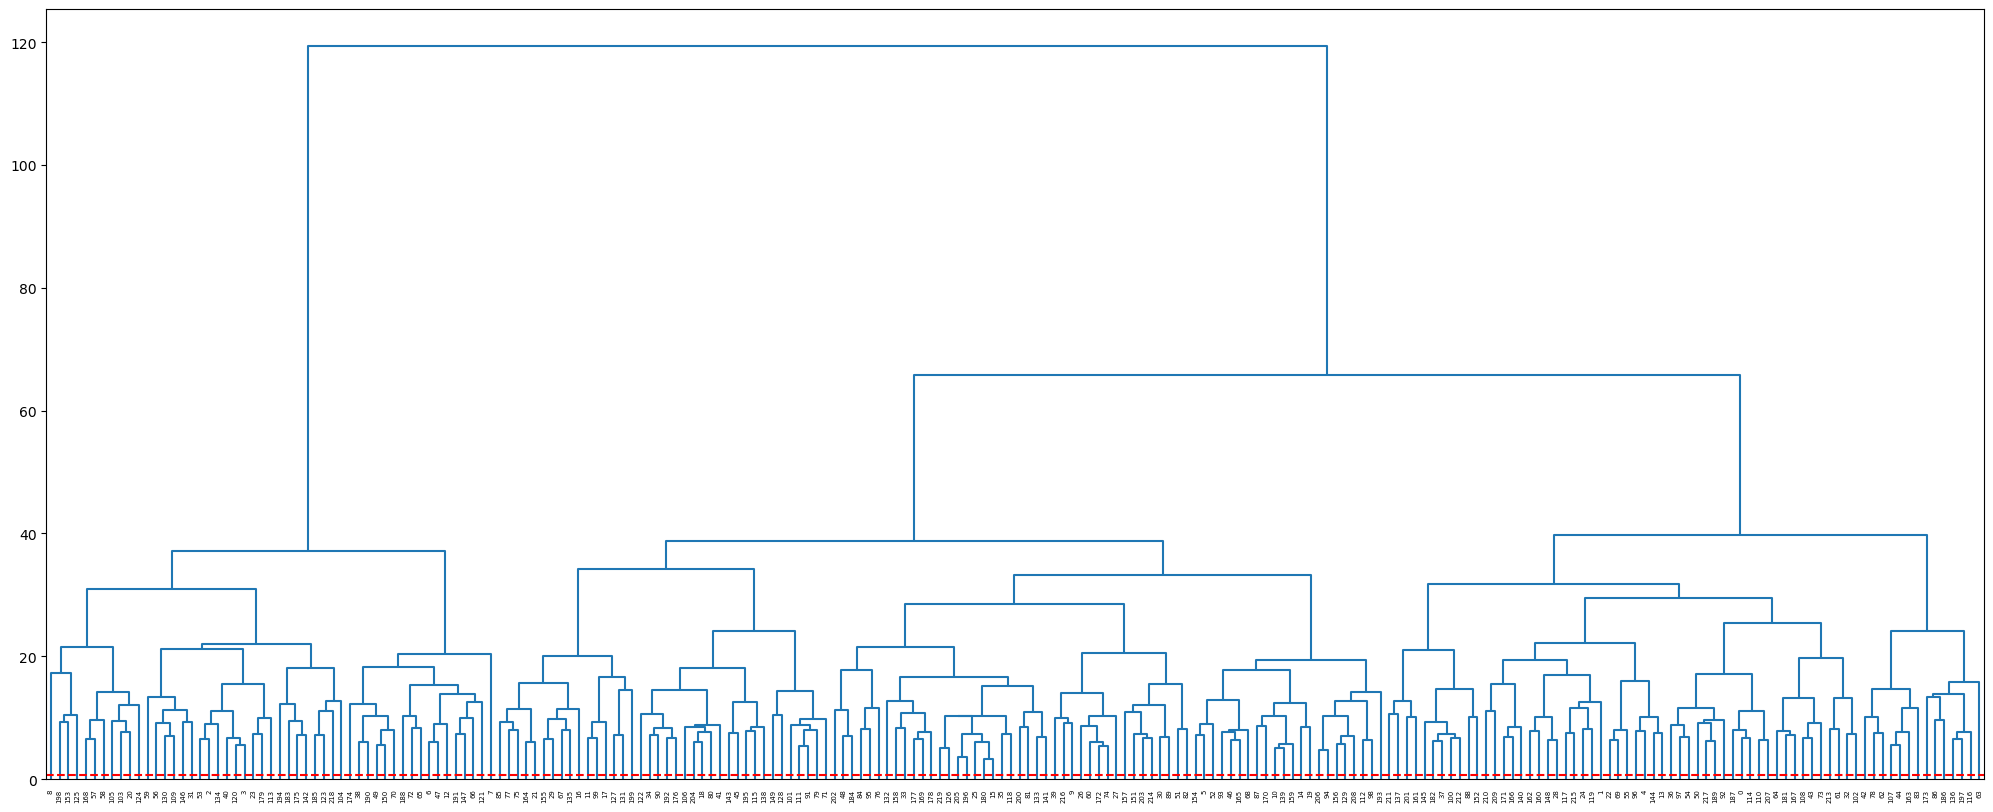

In [72]:
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_deep, color_threshold = 0.7)
plt.axhline(y=.7, c='r', linestyle='--')

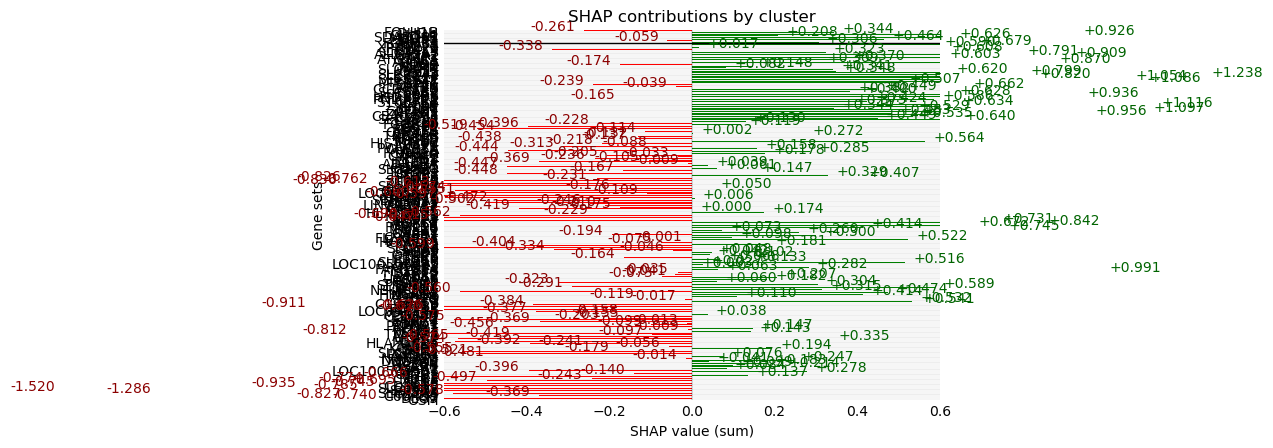

In [73]:
agg_df.plot.barh(x="cluster_labels", y="sum", legend=None, zorder=2, color=(agg_df['sum'] > 0).map({True: 'g',False: 'r'}))

plt.title('SHAP contributions by cluster')
plt.ylabel('Gene sets')
plt.xlabel('SHAP value (sum)')
plt.xlim((-.6,.6))
for i, v in enumerate(agg_df["sum"]):
    v = np.round(v, 3)
    vt = "+{:.3f}".format(v) if v >= 0 else "{:.3f}".format(v)
    offset = -.13 if v < 0 else .02
    colour = 'darkred' if v < 0 else 'darkgreen'
    plt.text(v + offset, i + .08, vt, color=colour, zorder=3)
    plt.axhline(i,linewidth=.07, color='k', zorder=1, linestyle='--')
    
    
plt.axvline(0,linewidth=.2, color='k')
plt.axhline(7.45,linewidth=1., color='k')

plt.tick_params(axis=u'both', which=u'both',length=0)
plt.gca().invert_yaxis()
plt.box(on=False)

plt.show()

gene names shown in sorted order;
can get full lists from dataframe;
clusters correspond to above dendrogram from left to right;
can choose threshold to get more / fewer clusters

In [74]:
# export to text file

for li in agg_df["grouped_genes"]:
    print(len(li),"genes:")
    for item in li:
        print(item)
    print("----------------------")

### Example: CD no ulcer patients

In [75]:
# patient_cluster_cd_deep = linkage(df_cd_deep, 'ward', metric='euclidean', optimal_ordering=True)
gene_cluster_cd_plain = linkage(df_cd_plain.T, 'ward', metric='euclidean', optimal_ordering=True)

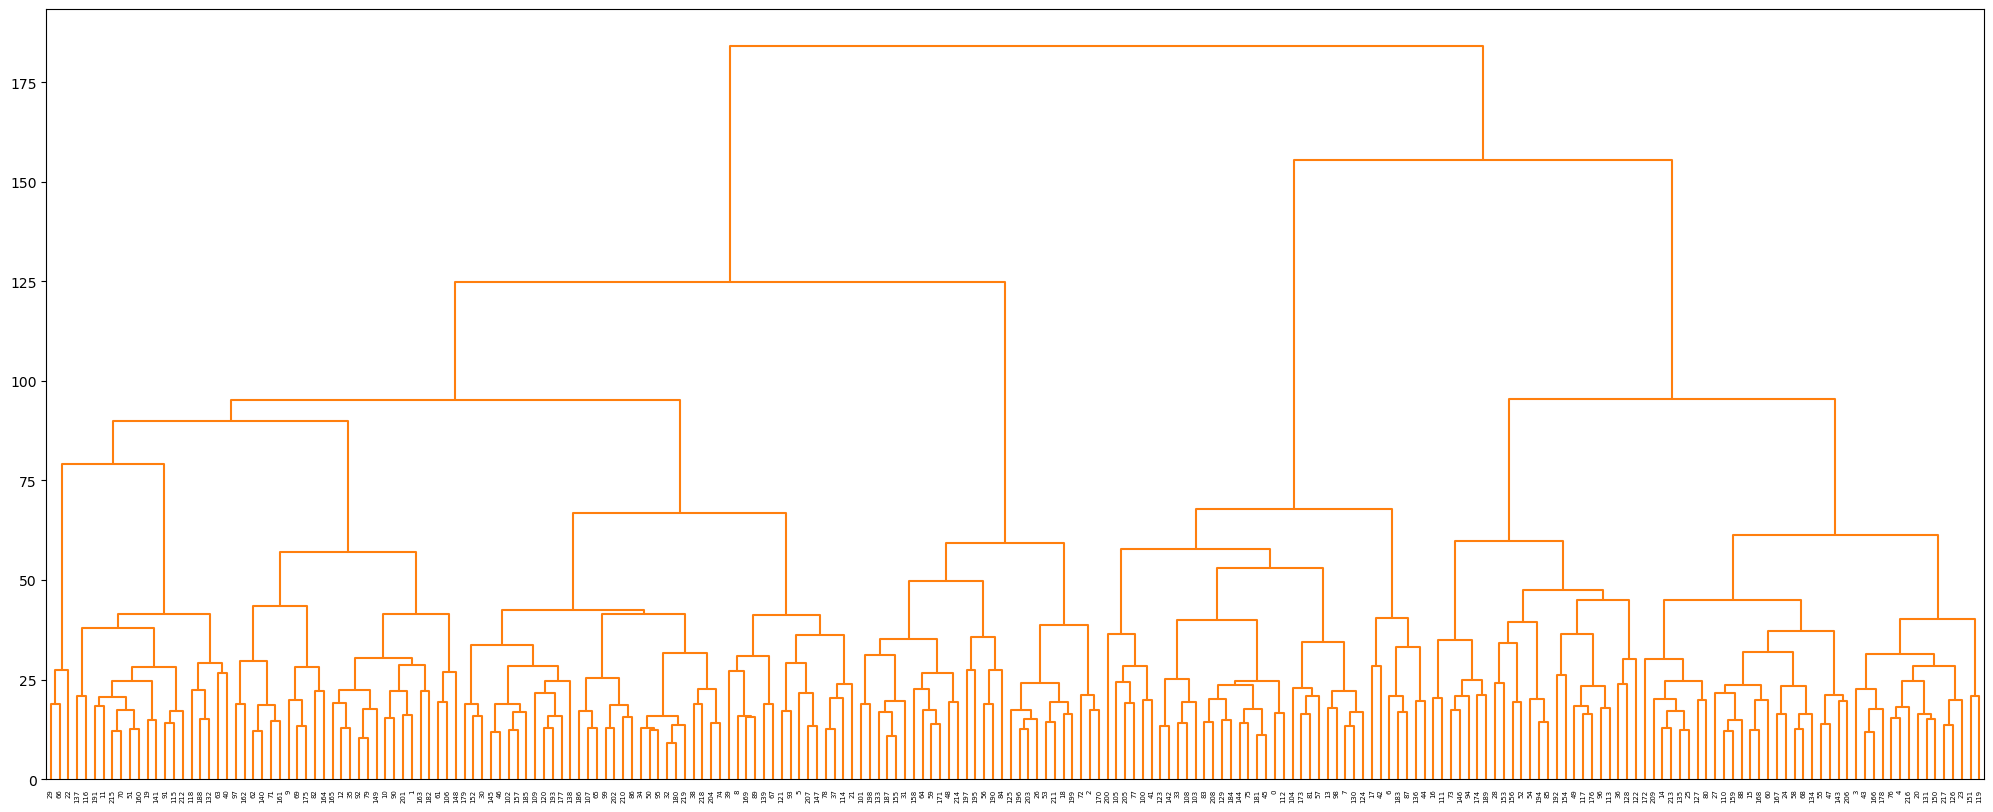

In [76]:

fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_plain, color_threshold = thresh)
# dn = dendrogram(fl)
plt.axhline(y=thresh, c='r', linestyle='--')

In [77]:
dn_ids = np.asarray(dn['ivl'], dtype='int')
dn_ids

array([ 29,  66,  22, 137, 116, 191,  11, 215,  70,  51, 160,  19, 141,
        91, 115, 212, 118, 188, 132,  63,  40,  97, 162,  62, 140,  71,
       161,   9,  69, 175,  82, 164, 165,  12,  35,  92,  79, 149,  10,
        90, 201,   1, 163, 182,  61, 106, 148, 179, 152,  30, 145,  46,
       102, 157, 185, 109, 120, 193, 177, 138, 186, 107,  65,  99, 202,
       210,  86,  34,  50,  95,  32, 180, 219,  38, 218, 204,  74,  39,
         8, 169,  89, 139,  67, 121,  93,   5, 207, 147,  78,  37, 114,
        21, 101, 198, 133, 187, 155,  31, 158,  64,  59, 171,  48, 214,
       197, 195,  56, 190,  84, 125, 196, 203,  26,  53, 211,  18, 199,
        72,   2, 170, 200, 105, 205,  77, 100,  41, 123, 142,  33, 108,
       103,  83, 208, 129, 184, 144,  75, 181,  45,   0, 112, 104, 173,
        81,  57,  13,  98,   7, 130, 124,  17,  42,   6, 183,  87, 136,
        44,  16, 111,  73, 146,  94, 174, 189,  28, 153, 156,  52,  54,
       194,  85, 192, 154,  49, 117, 176,  96, 113,  36, 128, 12

In [78]:
df_cd_plain.columns

Index(['AADAC', 'APOA1', 'APOA4', 'APOB', 'APOC3', 'AQP9', 'C6', 'CEACAM7',
       'CHI3L1', 'ABCC2',
       ...
       'HDLBP', 'PIAS4', 'ADH1B', 'LOC100507531', 'FAM83A', 'NXF4', 'RNF125',
       'DARS', 'DNAI1', 'MBTPS1'],
      dtype='object', length=220)

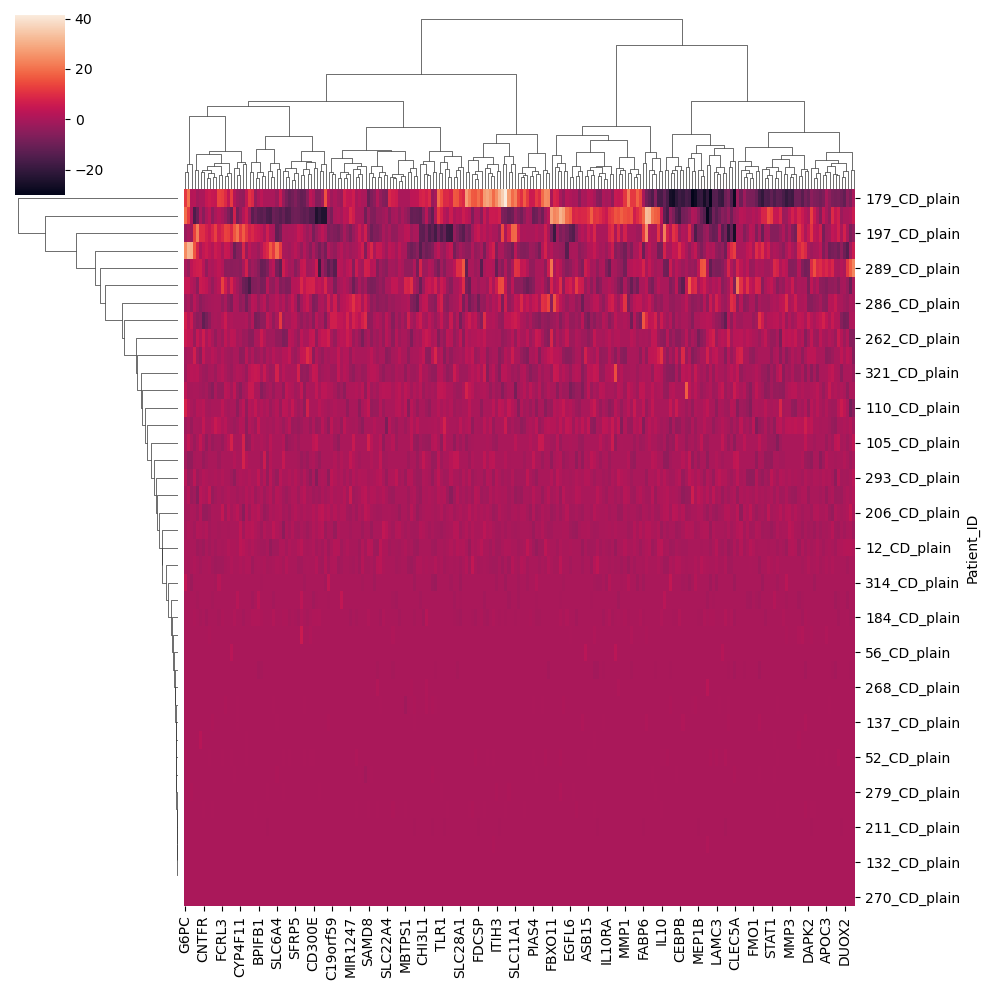

In [79]:
# shap values across genes (CD deep ulcer) - shows contribution of genes to disease symptom prediction for patients with given symptoms

# g = sns.clustermap(df_cd_deep, col_linkage=gc, row_linkage=patient_cluster_cd_deep)
g = sns.clustermap(df_cd_plain, col_linkage=gene_cluster_cd_plain)

## Aggregate bar plot, showing potential gene modules alongside SHAP contributions

In [80]:
gene_cluster_cd_plain

array([[ 32.        , 180.        ,   9.05751404,   2.        ],
       [ 92.        ,  79.        ,  10.22331302,   2.        ],
       [187.        , 155.        ,  10.72651313,   2.        ],
       [181.        ,  45.        ,  11.1601795 ,   2.        ],
       [145.        ,  46.        ,  11.8457851 ,   2.        ],
       [ 43.        , 166.        ,  11.87529358,   2.        ],
       [215.        ,  70.        ,  11.99988006,   2.        ],
       [110.        , 159.        ,  12.06498766,   2.        ],
       [ 62.        , 140.        ,  12.18081926,   2.        ],
       [102.        , 157.        ,  12.33589593,   2.        ],
       [ 50.        ,  95.        ,  12.35088538,   2.        ],
       [135.        ,  25.        ,  12.35783162,   2.        ],
       [ 15.        , 168.        ,  12.40455483,   2.        ],
       [ 51.        , 160.        ,  12.56056423,   2.        ],
       [196.        , 203.        ,  12.56732903,   2.        ],
       [ 78.        ,  37

In [81]:
cluster_labels = fcluster(gene_cluster_cd_plain, .8, criterion='distance')
# cluster_labels = fcluster(gene_cluster_cd_plain, 8, criterion='maxclust')
cluster_labels.shape

(220,)

In [82]:
leaders(gene_cluster_cd_plain, cluster_labels)

(array([ 29,  66,  22, 137, 116, 191,  11, 215,  70,  51, 160,  19, 141,
         91, 115, 212, 188, 132, 118,  63,  40,  97, 162,  62, 140,  71,
        161,  69, 175,   9,  82, 164,  12,  35, 165,  92,  79, 149,  10,
         90, 201,   1, 163, 182,  61, 106, 148, 152,  30, 179, 145,  46,
        102, 157, 185, 120, 193, 177, 109, 138, 107,  65, 186,  99, 202,
        210,  86,  50,  95,  34,  32, 180, 219,  38, 218, 204,  74, 169,
         89,   8,  39, 139,  67, 121,  93, 207, 147,   5,  78,  37, 114,
         21, 101, 198, 187, 155, 133,  31,  59, 171,  64, 158,  48, 214,
        197, 195,  56, 190,  84, 196, 203,  26, 125,  53, 211,  18, 199,
          2, 170,  72, 205,  77, 105, 100,  41, 200, 123, 142,  33, 108,
        103,  83, 208, 129, 184, 144,  75, 181,  45,   0, 112, 173,  81,
         57, 104,  13,  98,   7, 130, 124,  17,  42, 183,  87,   6, 136,
         44,  16, 111,  73, 146,  94, 174, 189,  28, 153, 156,  52, 194,
         85,  54, 192, 154, 117, 176,  49,  96, 113

In [83]:
leader_ids = leaders(gene_cluster_cd_plain, cluster_labels)[1]
leader_ids

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [84]:
cluster_labels

array([140,  42, 118, 209, 211,  88, 155, 148,  80,  30,  39,   7,  33,
       146, 182, 194, 158, 151, 116,  12, 215,  92,   3, 218, 198, 185,
       112, 193, 165,   1,  49,  98,  71, 129,  70,  34, 179,  90,  74,
        81,  21, 125, 152, 206, 157, 139,  52, 203, 103, 176,  68,  10,
       168, 114, 171, 202, 107, 144, 199,  99, 196,  45,  24,  20, 101,
        62,   2,  83, 200,  28,   9,  26, 120, 160,  77, 137, 210, 122,
        89,  37, 188, 143,  31, 132, 109, 170,  67, 154, 192,  79,  40,
        14,  36,  85, 162,  69, 177,  22, 147,  64, 124,  93,  53, 131,
       145, 123,  46,  61, 130,  59, 190, 159, 141, 178,  91,  15,   5,
       174,  19, 220,  56,  84, 181, 127, 150, 113, 217, 187, 180, 134,
       149, 213,  18,  97, 201, 184, 156,   4,  60,  82,  25,  13, 128,
       204, 136,  51, 161,  87,  47,  38, 214, 219,  48, 166, 173,  96,
       167,  54, 102, 191,  11,  27,  23,  43,  32,  35, 207, 197, 195,
        78, 119, 100, 189, 142, 163,  29, 175,  58, 208,  50,  7

In [85]:
gene_df = df_cd_plain.describe().T
gene_df['gene_symbol']  = df_cd_plain.columns
gene_df["group_num"] = cluster_labels

gene_df

,count,mean,std,min,25%,50%,75%,max,gene_symbol,group_num
AADAC,41.0,0.305663,3.171226,-10.899162,0.000000,0.0,1.078646,10.607330,AADAC,140
APOA1,41.0,-0.176895,3.221749,-15.088669,0.000000,0.0,0.000000,7.400867,APOA1,42
APOA4,41.0,0.754756,4.710930,-5.196233,0.000000,0.0,0.000000,24.572347,APOA4,118
APOB,41.0,0.697606,3.580328,-5.695900,0.000000,0.0,0.584711,12.955834,APOB,209
APOC3,41.0,-0.199862,2.312761,-6.550642,0.000000,0.0,0.062533,8.567651,APOC3,211
...,...,...,...,...,...,...,...,...,...,...
NXF4,41.0,-0.103850,2.472794,-8.389401,-0.097969,0.0,0.000000,7.060423,NXF4,8
RNF125,41.0,-0.294877,2.419645,-9.634215,0.000000,0.0,0.000000,5.701418,RNF125,212
DARS,41.0,-0.419992,2.338488,-9.281558,-0.243128,0.0,0.000000,5.755523,DARS,216
DNAI1,41.0,-0.439644,3.531380,-11.398676,-0.183283,0.0,0.197884,10.659447,DNAI1,75


In [86]:
# mean_df = gene_df[['mean','group_num']]
mean_df = gene_df[['mean','group_num','gene_symbol']]
mean_df

,mean,group_num,gene_symbol
AADAC,0.305663,140,AADAC
APOA1,-0.176895,42,APOA1
APOA4,0.754756,118,APOA4
APOB,0.697606,209,APOB
APOC3,-0.199862,211,APOC3
...,...,...,...
NXF4,-0.103850,8,NXF4
RNF125,-0.294877,212,RNF125
DARS,-0.419992,216,DARS
DNAI1,-0.439644,75,DNAI1


In [87]:

mean_df["gene_symbol"] = mean_df.index
mean_df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,mean,group_num,gene_symbol
AADAC,0.305663,140,AADAC
APOA1,-0.176895,42,APOA1
APOA4,0.754756,118,APOA4
APOB,0.697606,209,APOB
APOC3,-0.199862,211,APOC3
...,...,...,...
NXF4,-0.103850,8,NXF4
RNF125,-0.294877,212,RNF125
DARS,-0.419992,216,DARS
DNAI1,-0.439644,75,DNAI1


In [88]:
agg_df = mean_df.groupby(['group_num'])
agg_df = agg_df.apply(group_fn)
agg_df

,sum,gene_count,grouped_genes
group_num,,,
1,1.886309,1,[G6PC]
2,1.806457,1,[PTPN2]
3,0.711847,1,[FCN1]
4,0.605602,1,[FCRL4]
5,0.253899,1,[DLG5]
...,...,...,...
216,-0.419992,1,[DARS]
217,-0.533705,1,[DUOX2]
218,-0.507000,1,[FHIT]


In [89]:

# agg_df = mean_df.groupby(['group_num']).agg(sum=('mean','sum'), 
#       gene_count=('mean','count'), grouped_genes=('gene_symbol', 'mean', test))
# result = result.rename(columns={'categorize' : 'Buy/Sell'})
agg_df["cluster_labels"] = agg_df["grouped_genes"].apply(group_labels)
# agg_df["cluster_labels"] = agg_df["count"].apply(add_other)

agg_df['cluster_labels'] = agg_df.apply(lambda x: add_other(x["gene_count"], x["cluster_labels"]), axis=1)
agg_df

,sum,gene_count,grouped_genes,cluster_labels
group_num,,,,
1,1.886309,1,[G6PC],G6PC
2,1.806457,1,[PTPN2],PTPN2
3,0.711847,1,[FCN1],FCN1
4,0.605602,1,[FCRL4],FCRL4
5,0.253899,1,[DLG5],DLG5
...,...,...,...,...
216,-0.419992,1,[DARS],DARS
217,-0.533705,1,[DUOX2],DUOX2
218,-0.507000,1,[FHIT],FHIT


In [90]:
sorted_idxs = get_idx_order(dn_ids, df_cd_plain, agg_df)

In [91]:
# agg_df.index = leader_ids
agg_df.index = sorted_idxs
agg_df

,sum,gene_count,grouped_genes,cluster_labels
1,1.886309,1,[G6PC],G6PC
2,1.806457,1,[PTPN2],PTPN2
3,0.711847,1,[FCN1],FCN1
4,0.605602,1,[FCRL4],FCRL4
5,0.253899,1,[DLG5],DLG5
...,...,...,...,...
216,-0.419992,1,[DARS],DARS
217,-0.533705,1,[DUOX2],DUOX2
218,-0.507000,1,[FHIT],FHIT
219,-0.348983,1,[C9orf71],C9orf71


In [92]:
agg_df = agg_df.sort_index()
agg_df

,sum,gene_count,grouped_genes,cluster_labels
1,1.886309,1,[G6PC],G6PC
2,1.806457,1,[PTPN2],PTPN2
3,0.711847,1,[FCN1],FCN1
4,0.605602,1,[FCRL4],FCRL4
5,0.253899,1,[DLG5],DLG5
...,...,...,...,...
216,-0.419992,1,[DARS],DARS
217,-0.533705,1,[DUOX2],DUOX2
218,-0.507000,1,[FHIT],FHIT
219,-0.348983,1,[C9orf71],C9orf71


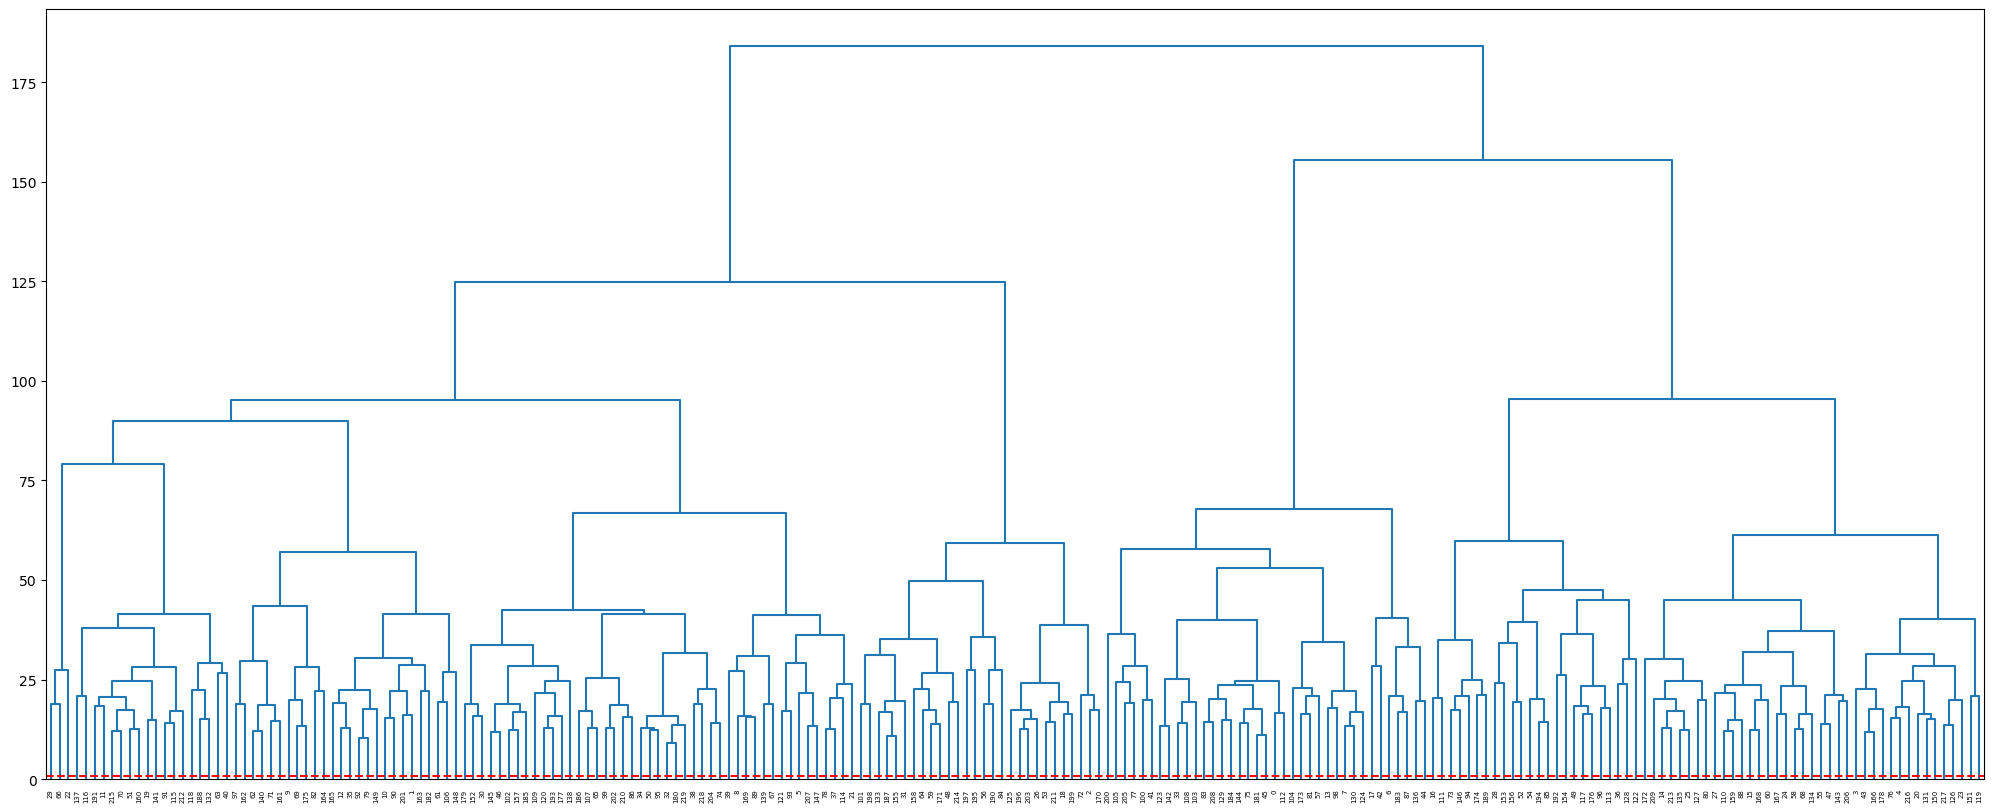

In [93]:
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_plain, color_threshold=.8, get_leaves=True)
plt.axhline(y=.8, c='r', linestyle='--')

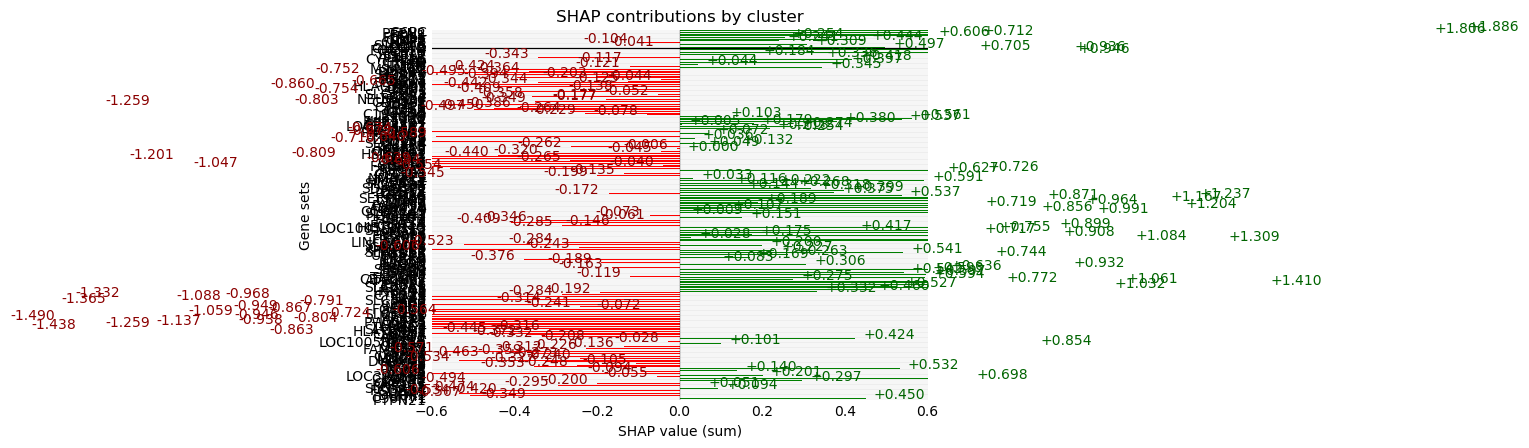

In [94]:
agg_df.plot.barh(x="cluster_labels", y="sum", legend=None, zorder=2, color=(agg_df['sum'] > 0).map({True: 'g',False: 'r'}))

plt.title('SHAP contributions by cluster')
plt.ylabel('Gene sets')
plt.xlabel('SHAP value (sum)')
plt.xlim((-.6,.6))
for i, v in enumerate(agg_df["sum"]):
    v = np.round(v, 3)
    vt = "+{:.3f}".format(v) if v >= 0 else "{:.3f}".format(v)
    offset = -.13 if v < 0 else .02
    colour = 'darkred' if v < 0 else 'darkgreen'
    plt.text(v + offset, i + .08, vt, color=colour, zorder=3)
    plt.axhline(i,linewidth=.07, color='k', zorder=1, linestyle='--')
    
    
plt.axvline(0,linewidth=.2, color='k')
size = fig.get_size_inches()[1]
plt.axhline(size + .045*size,linewidth=.9, color='k')

plt.tick_params(axis=u'both', which=u'both',length=0)
plt.gca().invert_yaxis()
plt.box(on=False)

plt.show()

gene names shown in sorted order;
can get full lists from dataframe
clusters correspond to above dendrogram from left to right
can choose threshold to get more / fewer clusters

In [95]:
# export to text file

for li in agg_df["grouped_genes"]:
    print(len(li),"genes:")
    for item in li:
        print(item)
    print("----------------------")